# init

In [1]:
# import required libs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import copy
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, kendalltau
from statistics import median, mean

In [2]:
gdata = pd.read_pickle('../pickle/gdata_aoa.p')

hdata = pd.read_pickle('../pickle/hdata_aoa.p')

In [3]:
def ranfor(df,train_size=0.8,n_estimators=150,criterion='squared_error',features=['degree','len','logfreq']):
    # select features for training
    X = df[features]
    y = df['age']
    # scale the data
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size)
    # train the regressor model
    ran_for_reg = RandomForestRegressor(n_estimators=n_estimators,
                                    criterion=criterion
                                   ).fit(X_train,y_train)
    pred = ran_for_reg.predict(X_test)
    true = y_test.to_numpy()
    return (pred,true)

In [4]:
def calc_correlations(pred,true):
    correlations = {}
    correlations['mse'] = mean_squared_error(pred,true)
    correlations['ktau'] = kendalltau(pred,true)[0]
    correlations['pval-ktau'] = kendalltau(pred,true)[1]
    correlations['pearsonr'] = pearsonr(pred,true)[0]
    correlations['pval-pearsonr'] = pearsonr(pred,true)[1]
    correlations['r2'] = r2_score(true, pred)
    return correlations

In [5]:
def pretty_corr(c): # pretty print output from calc_correlations()
    print(f"""
    Mean squared error (RMS): \t{c['mse']:.5f}\t({(c['mse']**.5):.5})
    Kendall Tau: \t\t{c['ktau']:.5}
    \tKtau p-value: \t\t{c['pval-ktau']:.5}
    Pearson's r: \t\t{c['pearsonr']:.5}
    \tPearson's r p-value: \t{c['pval-pearsonr']:.5}
    Coef. of determination \t{c['r2']:.5}
    """)

In [6]:
def met_avgs(met_list) -> dict: # given a list of dictionaries of metrics, return a dict of their averages
    keys = met_list[0].keys()
    list_len = len(met_list)
    ret_dict = {}
    for k in keys:
        ret_dict[k] = 0
    for d in met_list:
        for m in d:
            ret_dict[m] += d[m]
    for m in ret_dict:
        ret_dict[m]/=list_len
    
    return ret_dict

# Training and Plots

In [7]:
n_t = 150 # number of trees in the random forest regressor
ts = 0.8 # size of the training data in train_test_split

In [8]:
pairwise_results = ranfor(gdata,n_estimators = n_t, train_size = ts)
hypergraph_results = ranfor(hdata,n_estimators = n_t, train_size = ts)

In [9]:
hyp_pred, hyp_true = hypergraph_results # hypergraph model predicted and true values
gra_pred, gra_true = pairwise_results # graph model predicted and true values

In [10]:
hyp_corr = calc_correlations(hyp_pred,hyp_true)

In [11]:
gra_corr = calc_correlations(gra_pred,gra_true)

In [12]:
# Pretty print the correlations
print("-----------------------------------------")
print("Hypergraph ranking correlations:")
pretty_corr(hyp_corr)
print("-----------------------------------------")
print("Pair graph ranking correlations:")
pretty_corr(gra_corr)

-----------------------------------------
Hypergraph ranking correlations:

    Mean squared error (RMS): 	1.53845	(1.2403)
    Kendall Tau: 		0.38064
    	Ktau p-value: 		1.3742e-86
    Pearson's r: 		0.60337
    	Pearson's r p-value: 	5.3822e-120
    Coef. of determination 	0.34371
    
-----------------------------------------
Pair graph ranking correlations:

    Mean squared error (RMS): 	1.78864	(1.3374)
    Kendall Tau: 		0.30393
    	Ktau p-value: 		7.4161e-56
    Pearson's r: 		0.50988
    	Pearson's r p-value: 	1.8524e-80
    Coef. of determination 	0.22443
    


In [13]:
#get coefficients for line of best fit
hm, hb = np.polyfit(hyp_true,hyp_pred,1)
gm, gb = np.polyfit(gra_true,gra_pred,1)

[Text(0.5, 0, 'Empirical Age'),
 Text(0.5, 1.0, 'Pairwise Graph'),
 (2.0, 9.0),
 (1.0, 9.0),
 None]

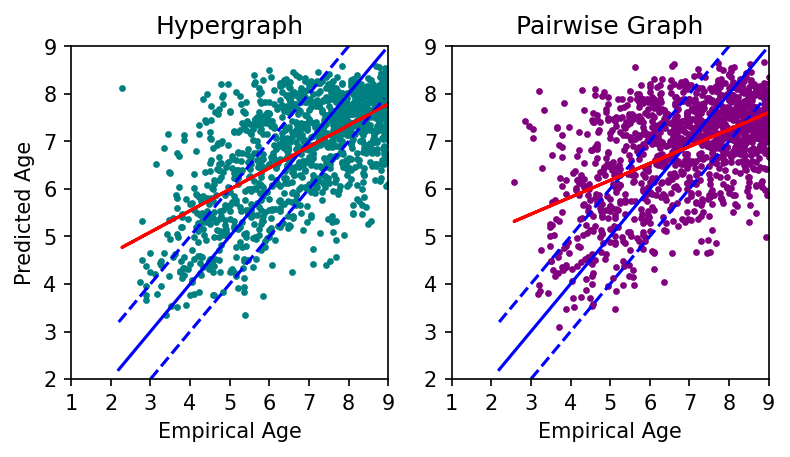

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, dpi=150)

ax1.scatter(hyp_true,hyp_pred, c='teal', s=5)

ax1.plot([2.2,8.9],[2.2,8.9],c='b')        # +/- 1 year margin lines
ax1.plot([2.2,8.9],[3.2,9.9],ls='--',c='b')#
ax1.plot([2.2,8.9],[1.2,7.9],ls='--',c='b')#

ax1.plot(hyp_true,hm*hyp_true+hb,c='red') # line of best fit
ax1.set(xlabel='Empirical Age',ylabel='Predicted Age',title='Hypergraph',
        ylim=[2,9],xlim=[1,9],xticks=list(range(1,10)),aspect=1.2)

ax2.scatter(gra_true,gra_pred, c='purple', s=5)

ax2.plot([2.2,8.9],[2.2,8.9],c='b')        # +/- 1 year margin lines
ax2.plot([2.2,8.9],[3.2,9.9],ls='--',c='b')#
ax2.plot([2.2,8.9],[1.2,7.9],ls='--',c='b')#

ax2.plot(gra_true,gm*gra_true+gb,c='red') # line of best fit

ax2.set(xlabel='Empirical Age',title='Pairwise Graph',
        ylim=[2,9],xlim=[1,9],xticks=list(range(1,10)),aspect=1.2)